### Loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
# Disable limit on number of figures
mpl.rc('figure', max_open_warning=0)

In [3]:
# Auxiliary for interspersing lists
def intersperse(iterable, delimiter):
    it = iter(iterable)
    yield next(it)
    
    for x in it:
        yield delimiter
        yield x

In [4]:
# Parse .non file to a contents object
def parse_non(path):
    with open(path) as f:
        lines = f.readlines()

    keys = ['height', 'width', 'rows', 'columns', 'goal']
    contents = {}

    i = 0

    for line in lines:
        for key in keys:
            if key in line:
                if key in ['height', 'width']:
                    contents[key] = int(line.split(' ')[1])
                elif key == 'rows':
                    rows_start = i
                elif key == 'columns':
                    columns_start = i
                elif key == 'goal':
                    contents[key] = list(map(int, line.split(' ')[1].replace('"','').replace('\n','')))

        i += 1

    rows_raw = lines[rows_start+1 : rows_start+1+contents['height']]
    columns_raw = lines[columns_start+1 : columns_start+1+contents['width']]

    rows, columns = [], []

    for row in rows_raw:
        rows.append(list(map(int, row.replace('\n','').split(','))))

    for col in columns_raw:
        columns.append(list(map(int, col.replace('\n','').split(','))))

    contents['row_hints'] = rows
    contents['column_hints'] = columns

    contents['max_row_hints'] = max(map(len, rows))
    contents['max_col_hints'] = max(map(len, columns))

    return contents

# Compare quantities computed from independent parts of the .non
def validate_read(contents):
    checks = {}

    # Check number of hints against dims
    len_row_hints, len_column_hints = len(contents['row_hints']), len(contents['column_hints'])

    checks['row_hint_against_dim'] = (len_row_hints == contents['height'])
    checks['col_hint_against_dim'] = (len_column_hints == contents['width'])

    # Check dims against length of goal
    checks['goal_len_against_dim'] = (contents['height']*contents['width'] == len(contents['goal']))

    # Check hints against goal
    goal_sum = sum(map(int, contents['goal']))

    sum_row_hints = sum(sum(contents['row_hints'], []))
    checks['row_hints_against_goal'] = (sum_row_hints == goal_sum)
    
    sum_column_hints = sum(sum(contents['column_hints'], []))
    checks['col_hints_against_goal'] = (sum_column_hints == goal_sum)

    # Check each hint in detail
    goal_state = get_goal_state(contents)
    row_against_hints, column_against_hints = True, True

    for i in range(contents['height']):
        if not sum(goal_state[i, :]) == sum(contents['row_hints'][i]):
            row_against_hints = False

    for j in range(contents['width']):
        if not sum(goal_state[:, j]) == sum(contents['column_hints'][j]):
            column_against_hints = False

    checks['row_against_hints'] = row_against_hints
    checks['column_against_hints'] = column_against_hints
    
    return checks

### Visualizations

In [5]:
# Plots state using matplotlib.matshow() and can also add element text to the plot
# Default fignum= behaviour is to use current axes
# elements_mat is the matrix of text (same shape as mat) to be plotted. 
def show_state(mat, fignum=0, ax=None, elements_mat=None, font_size=8.0, font_color=None, title=None):
    plt.matshow(np.sign(mat), cmap='Greys', fignum=fignum)

    if ax is None:
        print("No axes passed!")
        return

    # Plot text if elements_mat was passed
    if elements_mat is not None:
        if elements_mat.shape != mat.shape:
            print("mat and elements_mat have different shape!")
            return
    
        for i in range(mat.shape[0]):
            for j in range(mat.shape[1]):
                mat_el = elements_mat[i, j]

                if not np.isnan(mat_el):
                    mat_el = int(mat_el)

                    if font_color is None:
                        color = 'white' if mat_el > 0 else 'black'
                    else:
                        color = font_color

                    ax.text(
                        x=j, y=i,
                        s=mat_el,
                        ha='center', va='center',
                        fontsize=font_size,
                        color=color
                    )

    if title is not None:
        plt.title(title)

# Embed state matrix in a big plot-able matrix with hints
def embed_in_big_matrix(mat, contents):
    # Create big empty matrix
    big_mat = np.zeros(
        shape=(
            contents['max_col_hints'] + contents['height'],
            contents['max_row_hints'] + contents['width']
            ),
        dtype=np.int8
        )

    # Create element matrix as empty of the same shape
    element_mat = np.zeros_like(big_mat, dtype=np.float16)
    element_mat[:,:] = np.nan

    # Populate big_mat with mat
    big_mat[
        contents['max_col_hints'] : contents['max_col_hints'] + contents['height'],
        contents['max_row_hints'] : contents['max_row_hints'] + contents['width']
        ] = mat

    # Populate row hints
    for i in range(len(contents['row_hints'])):
        row_hint = contents['row_hints'][i]
        len_hint = len(row_hint)

        for j in range(len_hint):
            element_mat[
                contents['max_col_hints'] + i,
                contents['max_row_hints'] - len_hint + j
                ] = row_hint[j]

    # Populate column hints
    for j in range(len(contents['column_hints'])):
        col_hint = contents['column_hints'][j]
        len_hint = len(col_hint)

        for i in range(len_hint):
            element_mat[
                contents['max_col_hints'] - len_hint + i,
                contents['max_row_hints'] + j
                ] = col_hint[i]
    
    return big_mat, element_mat

# Plots mat together with hints
# Figure/axes need to be fixed before running this
def show_pretty_state(mat, contents, font_size=8.0, fignum=0, ax=None, title=None):
    big_mat, elements_mat = embed_in_big_matrix(mat, contents)

    if ax is None and fignum is not None:
        ax = plt.gca()
    elif ax is None and fignum is None:
        fig, ax = plt.subplots()
        fignum = 0

    show_state(big_mat, fignum=fignum, ax=ax, elements_mat=elements_mat, font_size=font_size, font_color='black', title=title)

# Fetch contents['goal'] as state
def get_goal_state(contents):
    goal = np.array(contents['goal'])
    return goal.reshape((contents['height'], contents['width']))

# Pretty-plots goal state
def show_goal_state(contents, name=None):
    goal_mat = get_goal_state(contents)

    fig, ax = plt.subplots()
    show_pretty_state(goal_mat, contents, fignum=0, ax=ax, title=f"Goal state {name}")

### Solving

In [6]:
class TooLargeRowSumException(Exception):
    def __init__(self):
        return

# Check if row is solved
# This means:
#   1) #{filled in cells} = sum(hint)
#   2) #{filled in cells} + #{blank cells} = dim
def row_is_solved(row, hint):
    # Check 1)
    filled_in_sum = (row > 0).sum()
    hint_sum = sum(hint)

    if filled_in_sum > hint_sum:
        raise TooLargeRowSumException()
    elif filled_in_sum < hint_sum:
        return False
    # else, go on to check 2)

    # Check 2)
    blank_sum = (row < 0).sum()
    dim = len(row)

    if filled_in_sum + blank_sum > dim:
        raise TooLargeRowSumException()
    elif filled_in_sum + blank_sum < dim:
        return False
    else:
        return True

# Dump state into format of contents['goal']
def dump_state(mat):
    mat = mat.copy()
    mat[mat < 0] = 0

    return list(mat.reshape(mat.shape[0]*mat.shape[1]))

# Check whether puzzle is solved
# Not very optimised to check row_is_solved() for all the rows.. Perhaps this can be integrated somewhere else
def puzzle_is_solved(mat, contents):
    # Check rows
    for i in range(contents['height']):
        if not row_is_solved(mat[i, :], contents['row_hints'][i]):
            return False
    
    # Check columns
    for j in range(contents['width']):
        if not row_is_solved(mat[:, j], contents['column_hints'][j]):
            return False

    # Check against goal
    return (dump_state(mat) == contents['goal'])

# #{Filled-in or blank cells}/#{Cells}
def get_completion_rate(mat):
    return ((mat > 0).sum() + (mat < 0).sum())/(mat.shape[0] * mat.shape[1])

In [61]:
# Fetches blocks of filled in cells in row in a hint format
def get_blocks(row):
    blocks = []
    current_block = 0
    len_row = len(row)

    for i in range(len_row+1):
        if i == len_row:
            if current_block > 0:
                blocks.append(current_block)
        elif row[i] <= 0 and current_block > 0:
            blocks.append(current_block)
            current_block = 0
        elif row[i] > 0:
            current_block += 1
    
    return blocks

# Find the leftmost possible configuration in a given row state
# It does not work for a row with hint [0]. This case should be handled by complete_zero_rows()
def get_leftmost_configuration(row, hint, fill_labels, blank_labels, debug=False):
    # Initial state of row: possible 1:s and -1:s
    dim = len(row)
    left = row.copy()
    index = 0

    for i in range(len(hint)):
        block = hint[i]
        # Counter for how off from initial position
        displace = 0
        
        while index < dim:
            # Create new candidate state
            row_sim = left.copy()
            
            # If first block, add padding of blanks to the left
            if i == 0:
                row_sim[0 : index+block] = blank_labels[0]
            elif displace > 0:
                row_sim[index-displace-1 : index] = blank_labels[i]

            # Try placing block
            row_sim[index : index+block] = fill_labels[i]

            # Add space after block
            # If last block, add padding of blanks to the right
            if i == len(hint)-1:
                row_sim[index+block :] = blank_labels[i+1]
            # Otherwise just add one blank cell
            else:
                row_sim[index+block : index+block+1] = blank_labels[i+1]

            # Compare current blocks with hint
            # TODO: I don't really know what the correct comparison here is 
            row_sim_blocks = get_blocks(row_sim)

            row_vs_hint_dict = {
                'len' : (i == len(hint)-1) and (len(row_sim_blocks) > len(hint)),
                'sum' : sum(row_sim_blocks) > sum(hint),
                'max if nonempty' : (max(row_sim_blocks) > max(hint)) if row_sim_blocks else False
            }

            row_vs_hint = max(row_vs_hint_dict.values())

            # Compare #{filled in cells} with correct number of filled in cells
            row_too_big = (row_sim > 0).sum() > sum(hint)

            # Bad overlap
            collision = (np.sign(row_sim) != np.sign(row)) & (np.sign(row_sim) != 0) & (np.sign(row) != 0)
            bad_overlap = max(collision)

            # Debug plot
            if debug:
                row_stack = np.row_stack([row, left, row_sim, collision])
                
                fig, ax = plt.subplots()
                plot_title = f"{hint}, block={i+1}/{len(hint)}, index={index}, displace={displace}\nrow_vs_hint={str(row_vs_hint_dict)}, row_too_big={row_too_big}"
                show_state(row_stack, fignum=0, ax=ax, elements_mat=row_stack, title=plot_title)

            # If there are cells in bad overlap
            if bad_overlap or row_vs_hint:
                # Try to move block a step to the right
                index += 1
                displace += 1

            # If there are no cells in bad overlap
            else:
                # Continue beyond new block
                index += block + 1

                # Keep state
                left = row_sim
                break

    # TODO: Error handling

    return left

# Find necessarily filled in cells in a given row state
def nec_cells_row(row, hint, debug=False, debug_plot=True): 
    # As many blocks as numbers in hint
    fill_labels = list(range(1, len(hint) + 1))
    # As many blanks as numbers in hint + 1 (allowing for two possibly zero-cell blanks at the endpoints)
    blank_labels = list(map(lambda x: -x, range(1, len(hint) + 2)))

    # Get leftmost possible configuration
    left = get_leftmost_configuration(
        row=row,
        hint=hint,
        fill_labels=fill_labels,
        blank_labels=blank_labels,
        debug=debug
        )

    if debug:
        print("Found leftmost configuration\n")

    # Get rightmost possible configuration
    right = np.flip(
        get_leftmost_configuration(
            row=np.flip(row),
            hint=list(reversed(hint)),
            fill_labels=list(reversed(fill_labels)),
            blank_labels=list(reversed(blank_labels)),
            debug=debug
            )
            )

    if debug:
        print("Found rightmost configuration\n")

    # Overlap in booleans - have to compare blocks
    good_overlap = (left == right)

    # Resulting row
    row_out = left.copy()
    row_out[~good_overlap] = row[~good_overlap]
    
    if debug_plot:
        fig, ax = plt.subplots()
        
        row_stack = np.row_stack([row, left, right, row_out])
        show_state(row_stack, fignum=0, ax=ax, elements_mat=row_stack, title=str(hint))

    return np.sign(row_out)

# Find necessarily filled in cells in a matrix
def nec_cells_matrix(mat, contents, debug):
    new_mat_rows = []

    # Row-wise check of necessary cells
    # Iterate over rows of matrix
    for i in range(contents['height']):
        row = mat[i, :]
        hint = contents['row_hints'][i]
        
        # If row is complete there is no need to check
        if not row_is_solved(row, hint):
            row = nec_cells_row(
                row=row,
                hint=hint,
                debug=False,
                debug_plot=debug
                )

        new_mat_rows.append(row)

    new_row_mat = np.row_stack(new_mat_rows)

    new_mat_cols = []

    # Column-wise check of necessary cells
    # Iterate over rows of transposed matrix
    for j in range(contents['width']):
        col = mat[:, j]
        hint = contents['column_hints'][j]

        # If column is complete there is no need to check
        if not row_is_solved(col, hint):
            col = nec_cells_row(
                row=new_row_mat[:, j],
                hint=contents['column_hints'][j],
                debug=False,
                debug_plot=debug
            )

        new_mat_cols.append(col)

    new_col_mat = np.column_stack(new_mat_cols)

    return new_row_mat, new_col_mat

# Set all cells to blank in rows with hint [0]
def complete_zero_rows(mat, contents):

    for i in range(contents['height']):
        hint = contents['row_hints'][i]

        if sum(hint) == 0:
            mat[i, :] = -1

    for j in range(contents['width']):
        hint = contents['column_hints'][j]

        if sum(hint) == 0:
            mat[:, j] = -1

    return mat

# First-order solver
def solver_v1(contents, init_mat=None, plot=False):
    # Create empty initial state if none is passed
    if init_mat is None:
        shape = (contents['height'], contents['width'])
        init_mat = np.full(shape, fill_value=0, dtype=np.int8)

    if plot:
        # Print initial state
        show_pretty_state(init_mat, contents, fignum=None)

    # Set all rows with hint [0] to -1
    mat = complete_zero_rows(init_mat, contents)

    while True:
        new_row_mat, new_col_mat = nec_cells_matrix(mat, contents, debug=False)

        if (new_col_mat == mat).min():
            print("Unchanged")
            break

        mat = new_col_mat

        if plot:
            show_pretty_state(mat, contents, fignum=None, title=f"{int(np.floor(get_completion_rate(mat)*100))}% completed")

        if puzzle_is_solved(mat, contents):
            print("Solved")
            break

    return mat

### Test specific rows

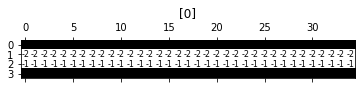

In [56]:
hint = [0]
dim = 35

row = np.full(dim,0,dtype=np.int8)

row_out = nec_cells_row(row,hint,False,True)

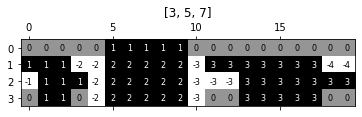

In [57]:
dim = 20
hint = [3, 5, 7]

row = np.full(dim, 0, dtype=np.int8)
row[5:5+5] = 1

row_out = nec_cells_row(row, hint,False,True)

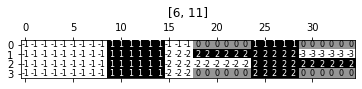

In [58]:
hint = [6,11]
dim = 35

row = np.full(dim,0,dtype=np.int8)
row[0:9] = -1
row[9:15] = 1
row[15:18] = -1
row[24:29] = 1

row_out = nec_cells_row(row,hint,False,True)

Found leftmost configuration

Found rightmost configuration



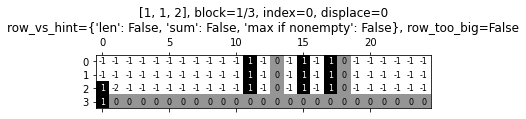

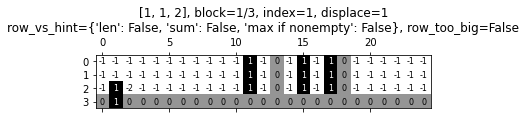

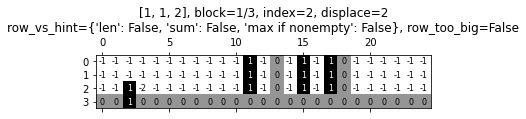

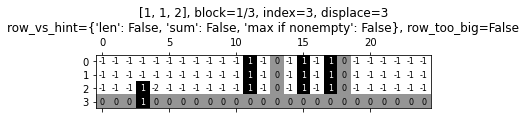

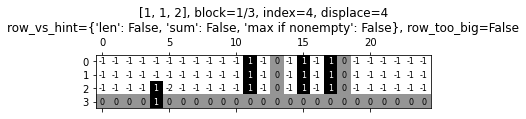

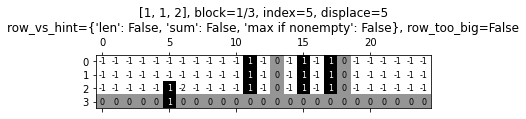

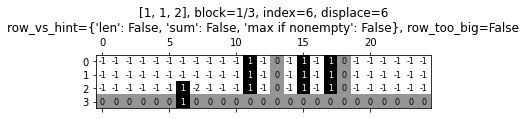

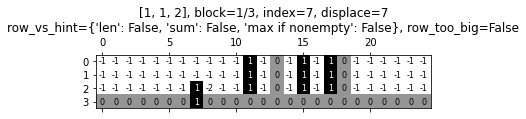

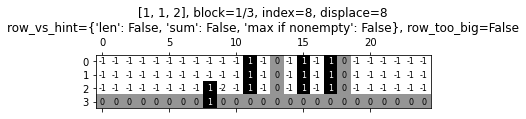

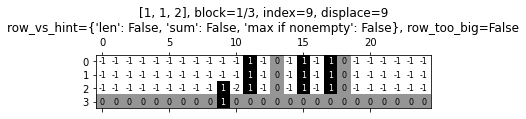

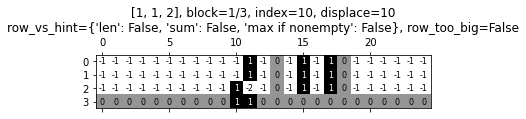

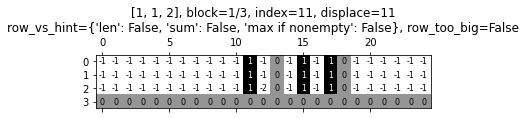

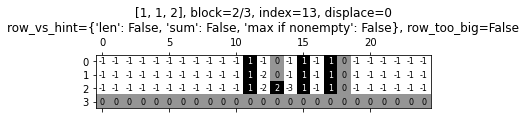

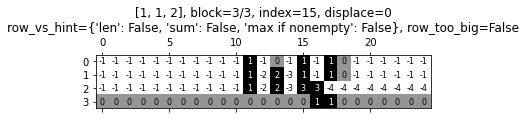

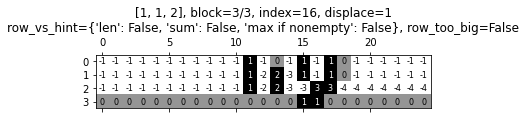

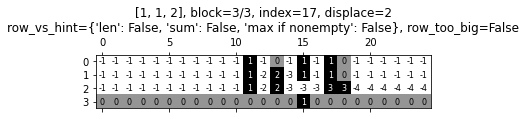

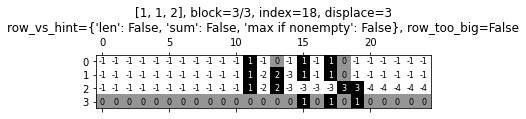

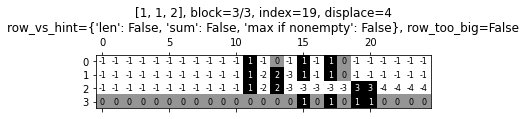

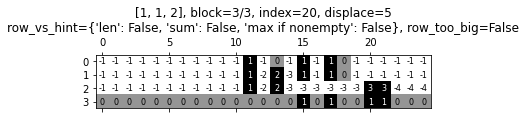

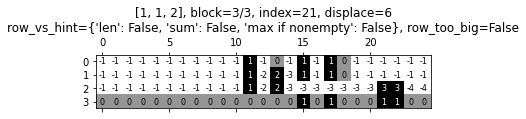

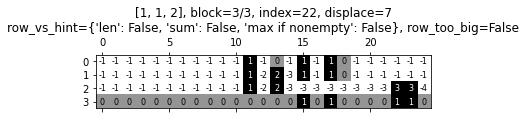

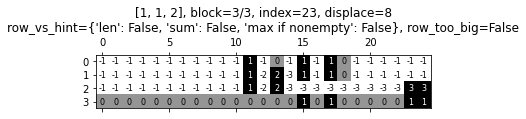

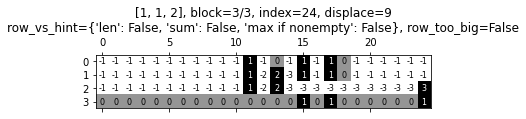

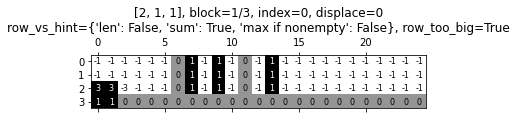

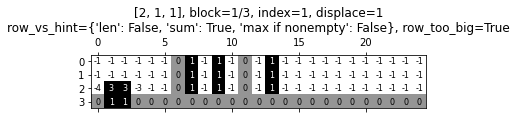

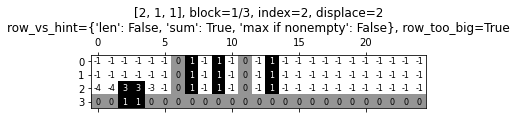

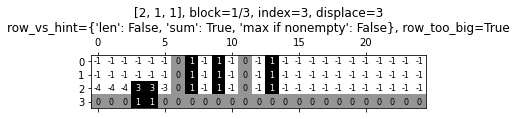

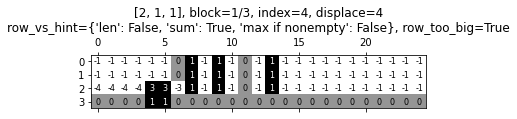

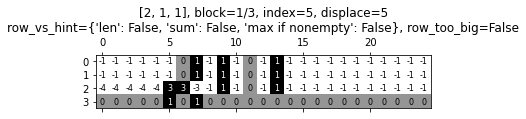

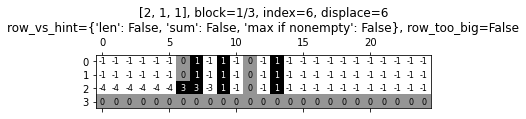

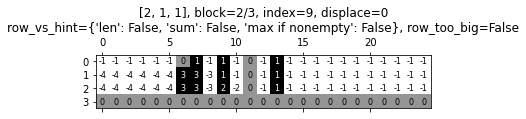

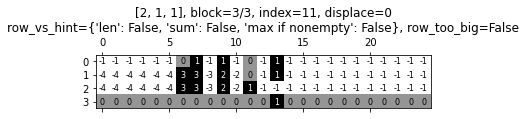

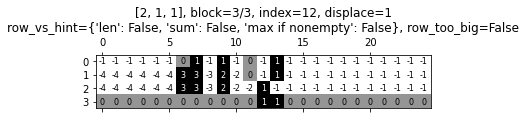

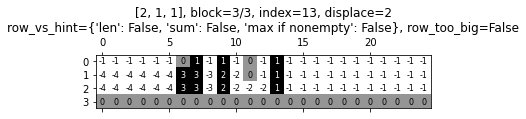

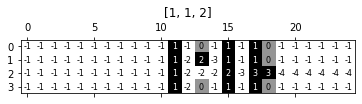

In [62]:
hint = [1,1,2]
dim=25
row = np.full(dim,0,dtype=np.int8)
row[0:11] = -1
row[11] = 1
row[12] = -1
row[14] = -1
row[15] = 1
row[16] = -1
row[17] = 1
#row[18] = -1
row[19:] = -1
row_out = nec_cells_row(row,hint,True,True)

Found leftmost configuration

Found rightmost configuration







--------------------
Row
--------------------
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  0  0 -1  0
  1  0  1  1  1  0  1  1  0 -1 -1]
--------------------
Left
--------------------
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  0  0 -1  0
  1  0  1  1  1  0  1  1  0 -1 -1]
--------------------
Right
--------------------
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -2 -2 -2 -2 -2 -2 -2 -2 -2
  2  2  2  2  2  2  2  2 -3 -3 -3]
--------------------
Good overlap
--------------------
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False False False False False False False False
 False False False False False False False False False False False]
--------------------
Row out
--------------------
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  0  0 -1  0
  1  0  1  1  1  0  1  1  0 -1 -1]


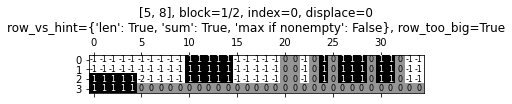

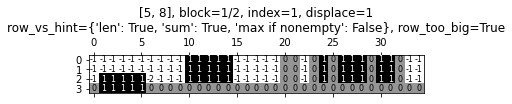

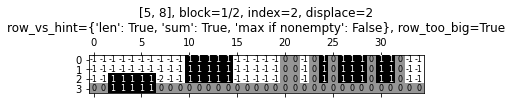

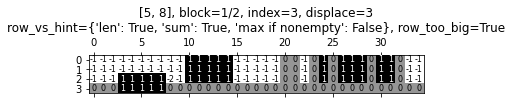

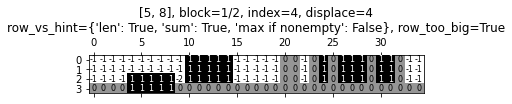

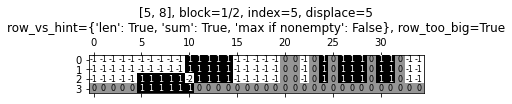

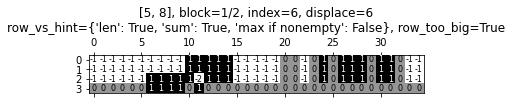

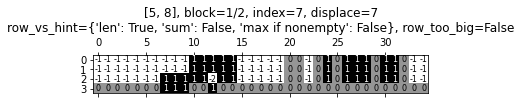

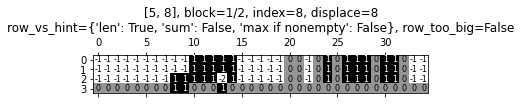

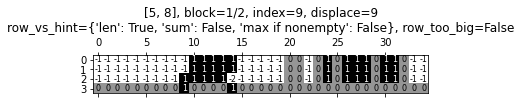

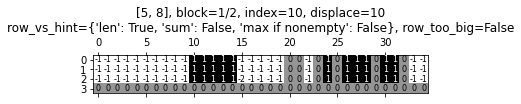

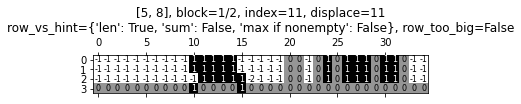

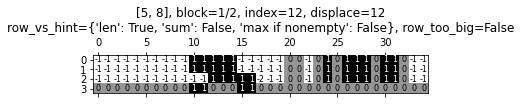

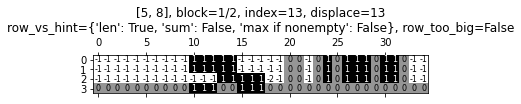

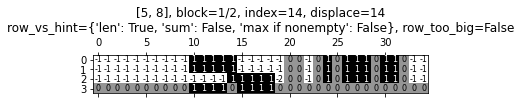

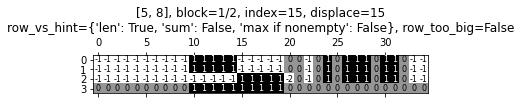

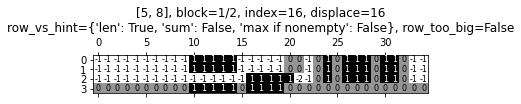

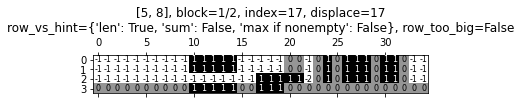

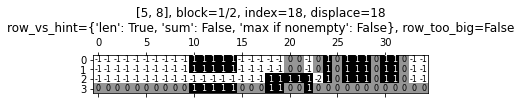

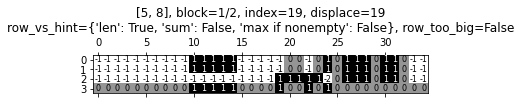

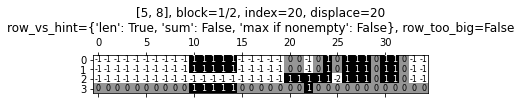

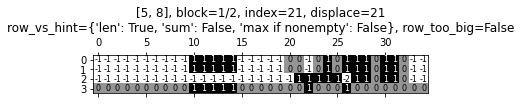

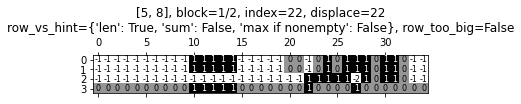

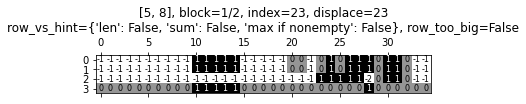

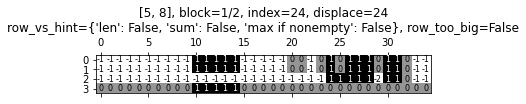

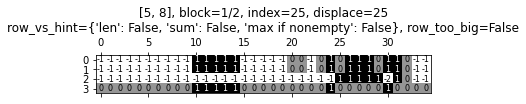

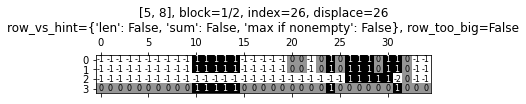

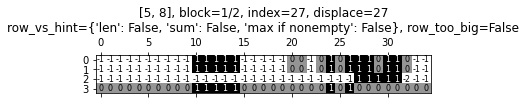

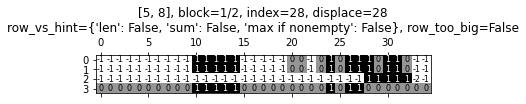

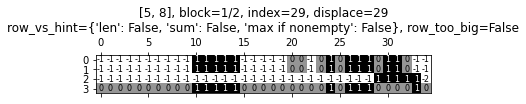

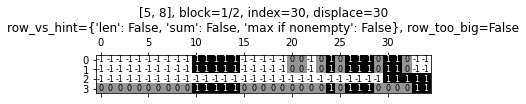

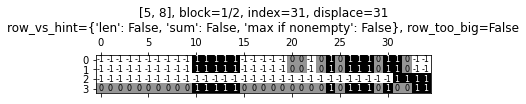

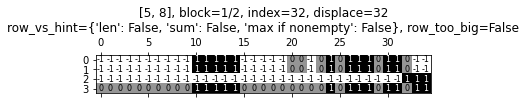

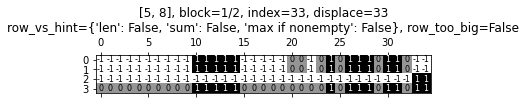

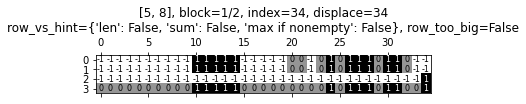

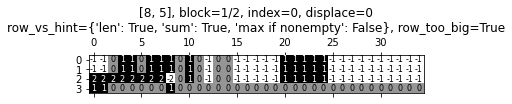

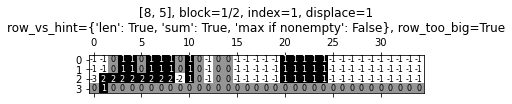

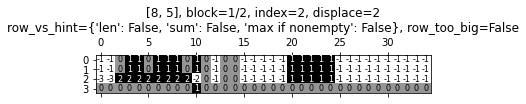

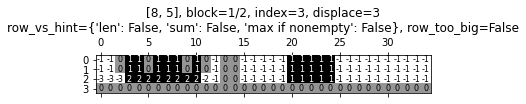

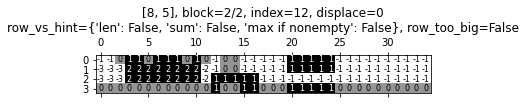

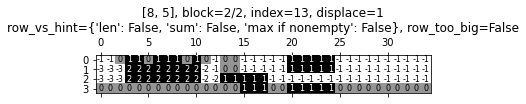

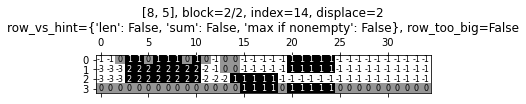

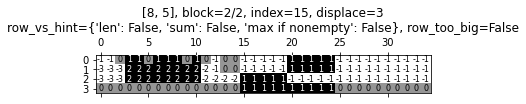

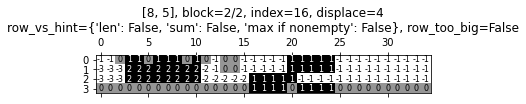

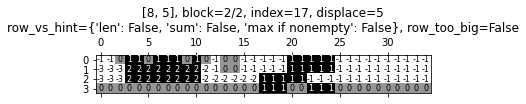

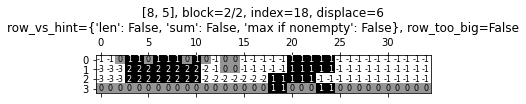

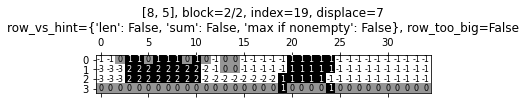

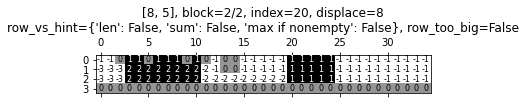

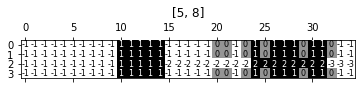

In [54]:
hint = [5,8]
dim=35
row = np.full(dim,0,dtype=np.int8)
row[0:10] = -1
row[10:15] = 1
row[15:20] = -1
row[22] = -1
row[24] = 1
row[26:29] = 1
row[30:32] = 1
row[-2:] = -1
row_out = nec_cells_row(row,hint,True,True)

### Fetch specific puzzles

In [41]:
# 42
sample_nonogram_path = r"C:\Users\inno\Documents\projects\z_aux\nonogram-db\db\gnonograms\42.non"
contents = parse_non(sample_nonogram_path)

In [ ]:
# Camel
# Simple example that requires higher-order methods
nt_rh = [[2],[1,1],[4],[3],[1,1]]
nt_ch = [[3],[3],[3],[3],[1]]

contents = {
    'height' : 5,
    'width' : 5,
    'row_hints' : nt_rh,
    'column_hints' : nt_ch,
    'max_row_hints' : max(map(len, nt_rh)),
    'max_col_hints' : max(map(len, nt_ch)),
    'goal' : list('0001101010111101110010100')
}

init_mat = np.full((5,5), fill_value=0, dtype=np.int8)

In [ ]:
# Another higher-order
nt_rh = [[3,2],[2,2],[2,2,1],[2,1],[2,3],[3,2],[3],[3],[3],[3],[3],[3],[3],[3],[2]]
nt_ch = [[2],[3],[3],[3],[3],[3],[3],[3],[2,3],[3,3],[1,3],[1,2],[2,2],[2,2],[1,3]]

contents = {
    'height' : len(nt_rh),
    'width' : len(nt_ch),
    'row_hints' : nt_rh,
    'column_hints' : nt_ch,
    'max_row_hints' : max(map(len, nt_rh)),
    'max_col_hints' : max(map(len, nt_ch))
}



### Point usage of solver

(array([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1, -1,
         -1, -1, -1, -1,  0,  0, -1,  0,  1,  0,  1,  1,  1,  0,  1,  1,
          0, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1,
         -1, -1, -1, -1, -1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          0, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1,
         -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1, -1],
        [-1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
         -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,
          1,  1, -1],
        [-1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
         -1, -1, -1, -1,  0,  0,  1,  0,  1,  0, -1, -1, -1,  0,  1,  1,
          1,  

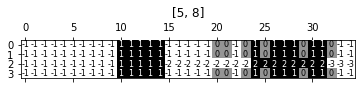

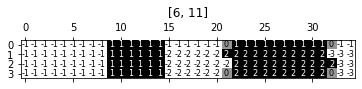

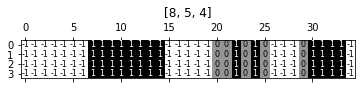

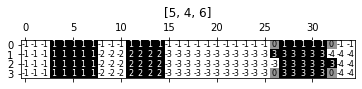

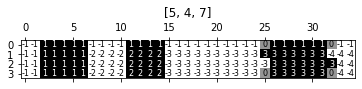

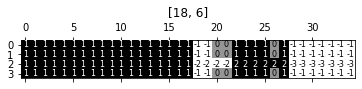

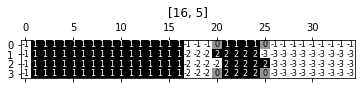

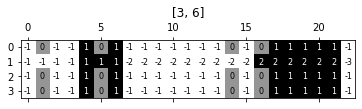

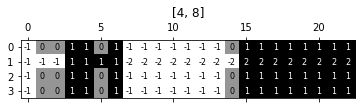

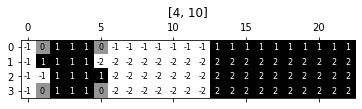

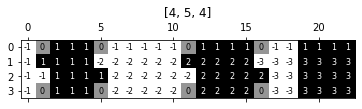

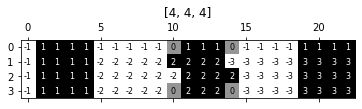

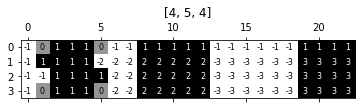

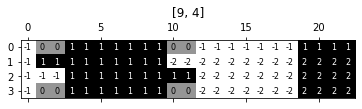

In [43]:
nec_cells_matrix(mat, contents, debug=True)

Unchanged


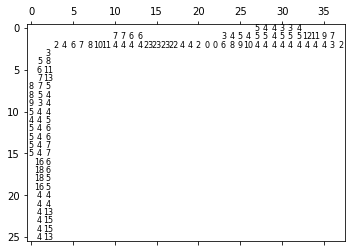

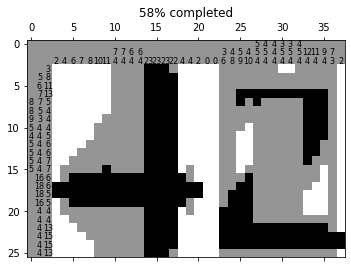

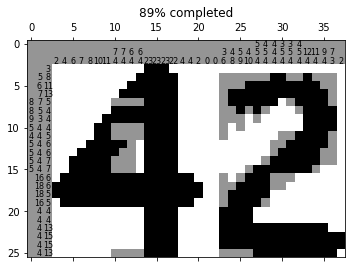

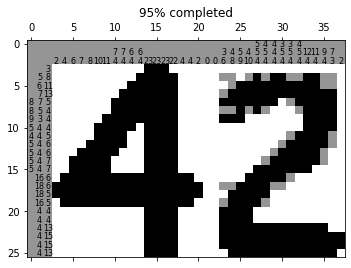

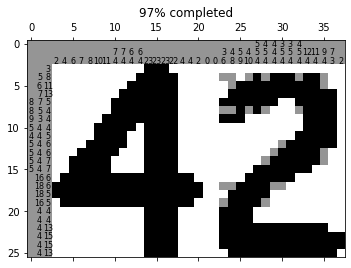

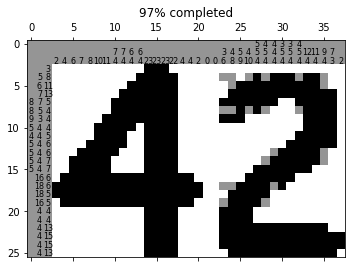

In [42]:
mat = solver_v1(contents, plot=True)

### Loop over puzzle database of `nonogram-db`

In [ ]:
import os

nono_dir = r"C:\Users\inno\Documents\projects\z_aux\nonogram-db\db"

puzzles = {}
plot = False

# Iterate over path
for subdir, dirs, files in os.walk(nono_dir):
    for file in files:
        filename = os.fsdecode(file)

        if filename.endswith('.non'):
            # Fetch puzzle object
            filepath = os.path.join(subdir, filename)
            contents = parse_non(filepath)
            contents['filepath'] = filepath

            print(filepath)

            # Validate contents
            validation = validate_read(contents)
            contents['validation'] = validation

            for key in validation:
                if not validation[key]:
                    print(validation[key])

            if plot:
                # Plot goal
                show_goal_state(contents, name=filename)

            # Solve
            mat = solver_v1(contents, plot=plot)
            contents['result_mat'] = mat
            contents['completion'] = get_completion_rate(mat)

            puzzles[filepath] = contents

In [ ]:
contents = parse_non(r"C:\Users\inno\Documents\projects\z_aux\nonogram-db\db\gnonograms\gnome.non")
#solver_v1(contents)

init_mat = np.full((contents['height'],contents['width']),fill_value=0,dtype=np.int8)
row_mat, col_mat = nec_cells_matrix(init_mat,contents,debug=False)

In [ ]:
row_mat, col_mat = nec_cells_matrix(col_mat,contents,debug=False)

In [ ]:
show_pretty_state(col_mat, contents)

In [ ]:
row_mat2, col_mat2 = nec_cells_matrix(col_mat,contents,debug=True)

In [ ]:
barely_incomplete_puzzles = []
completed_puzzles = []

for puzzle in puzzles:
    completion = puzzles[puzzle]['completion']
    if completion == 1:
        completed_puzzles.append(puzzles[puzzle])
    elif completion > 0.95:
        barely_incomplete_puzzles.append(puzzles[puzzle])

In [ ]:
print(f"barely incomplete={len(barely_incomplete_puzzles)/len(puzzles)}")
print(f"completed={len(completed_puzzles)/len(puzzles)}")

In [ ]:
puzzle = barely_incomplete_puzzles[-1]

puzzle.keys()
result_mat = puzzle['result_mat']

In [ ]:
puzzle['filepath']
# 'C:\\Users\\inno\\Documents\\projects\\z_aux\\nonogram-db\\db\\qnonograms\\examples\\candle.non'

In [ ]:
show_pretty_state(result_mat, puzzle)

In [ ]:
index = -4
nec_cells_row(result_mat[:,index],puzzle['column_hints'][index],debug=True,debug_plot=True)